<a href="https://colab.research.google.com/github/lnalborczyk/ilcb_deep_learning_2022/blob/master/code/emg_classification_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying surface EMG signals using 1D convolutionnal neural networks

Written by Ladislas Nalborczyk (LPC, LNC, CNRS, AMU). Last updated on February 22, 2022.

# New section

In [1]:
# installing tensorflow
install.packages("tensorflow")
library(tensorflow)
# install_tensorflow()

# installing keras
install.packages("keras")
library(keras)
# install_keras()

# loading the tidyverse package (data wrangling and plotting)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppTOML’, ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [9]:
system("git clone https://github.com/lnalborczyk/ilcb_deep_learning_2022.git", intern=TRUE)

character(0)

In [13]:
# loading input features
x_reshaped <- readRDS("/content/ilcb_deep_learning_2022/data/x.rds")

In [14]:
# (6 reps x 20 words x 22 participants) x 1 sec x 2 muscles
dim(x_reshaped)

[1] 2640 1000    2

In [15]:
# loading labels
y <- readRDS("/content/ilcb_deep_learning_2022/data/y.rds")

In [16]:
# 6 reps x 20 words x 22 participants
length(y)

[1] 2640

In [17]:
# train/test split (80%)
b <- 0.8 * nrow(x_reshaped)
x_train <- x_reshaped[1:b, , ]
x_test <- x_reshaped[(b + 1):nrow(x_reshaped), , ]
c(dim(x_train), dim(x_test) )

[1] 2112 1000    2  528 1000    2

In [18]:
# dummy encoding of labels
num_classes <- n_distinct(y) %>% as.numeric
y_categ <- to_categorical(y = y, num_classes = num_classes)

Loaded Tensorflow version 2.8.0



In [19]:
# train/test split
y_train <- y_categ[1:b, ]
y_test <- y_categ[(b + 1):nrow(y_categ), ]

In [20]:
# input_shape should be [samples, time_steps, features]
model <- keras_model_sequential()

In [21]:
model %>%
    layer_conv_1d(
        filters = 40, kernel_size = 10, strides = 2,
        padding = "same", activation = "relu",
        input_shape = c(dim(x_reshaped)[2], dim(x_reshaped)[3])
        ) %>%
    layer_dropout(rate = 0.2) %>%
    layer_max_pooling_1d(pool_size = 3) %>%
    layer_conv_1d(
        filters = 32, kernel_size = 5, strides = 2,
        padding = "same", activation = "relu"
        ) %>%
    layer_dropout(rate = 0.2) %>%
    layer_max_pooling_1d(pool_size = 3) %>%
    layer_global_max_pooling_1d() %>%
    layer_dense(units = 64, activation = "relu") %>%
    layer_dropout(rate = 0.3) %>% 
    layer_dense(units = num_classes, activation = "softmax")

summary(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv1d_1 (Conv1D)                  (None, 500, 40)                 840         
                                                                                
 dropout_2 (Dropout)                (None, 500, 40)                 0           
                                                                                
 max_pooling1d_1 (MaxPooling1D)     (None, 166, 40)                 0           
                                                                                
 conv1d (Conv1D)                    (None, 83, 32)                  6432        
                                                                                
 dropout_1 (Dropout)                (None, 83, 32)                  0           
                                                                                
 max_poo

In [22]:
model %>%
    compile(
        loss = "categorical_crossentropy",
        optimizer = "adam",
        metrics = c("accuracy") # could be "binary_accuracy" or "categorical_accuracy"
        )

In [23]:
history <- model %>%
    fit(
        x_train, y_train,
        epochs = 20,
        batch_size = 10,
        validation_split = 0.2
        # callbacks = list(
        #     callback_early_stopping(monitor = "val_loss", patience = 10, verbose = 1)
        #     )
        )

In [25]:
# validation accuracy is around 75% just using the OOI...
# validation accuracy is around 80% when using both the OOI and the ZYG...
# validation accuracy is around 80% when using all four facial muscles (OOI, ZYG, COR, FRO)...
# NB: it was 0.848 [0.816, 0.877] using random forest and all four facial muscles...

# plots evolution of accuracy and loss (categorical cross-entropy)

`geom_smooth()` using formula 'y ~ x'



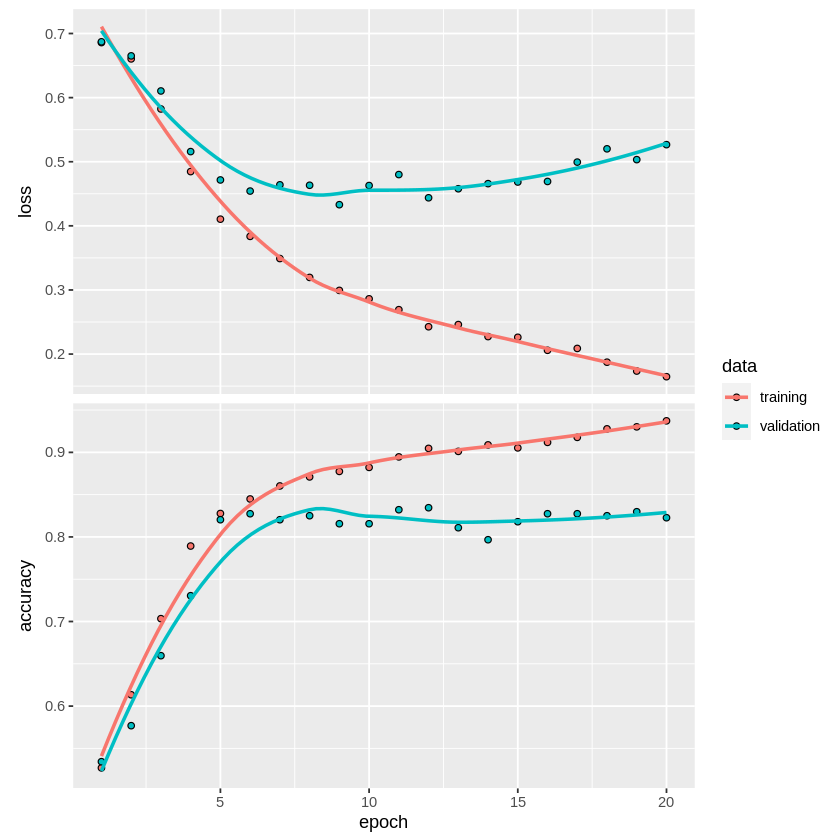

In [24]:
plot(history)

In [26]:
# evaluating the model's predictions
model %>% evaluate(x_test, y_test)

loss  accuracy 
0.3882649 0.8787879

In [27]:
# makes predictions
predictions <- model %>% predict(x_test) %>% k_argmax() %>% k_get_value()

In [28]:
expected_value <- y[(b+1):nrow(y_categ)]

In [29]:
# confusion matrix
table(predictions, expected_value)

           expected_value
predictions   0   1
          0 238  38
          1  26 226

In [30]:
# saves the entire model
save_model_hdf5(model, "models/emg_1d_cnn_model_overt.h5")
loaded_model <- load_model_hdf5("models/emg_1d_cnn_model_overt.h5")

In [31]:
# saves JSON config
json_config <- model_to_json(model)
writeLines(json_config, "models/emg_1d_cnn_model_config_overt.json")